In [1]:
import os
import PIL
import cv2
import scipy
import pathlib
import winsound
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm as notebook_tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline 

## Dataset
The textile fabric database consists of 245 images of 7 different fabrics. There are 140 defect-free images, 20 for each type of fabric. With different types of defects, there are 105 images.

Images have a size of 4096×256 pixels. Defective images have been denominated as follows: nnnn_ddd_ff.png, where nnnn is the image number, ddd is the defect code, and ff is the fabric code.

In [2]:
dataset_folder = "..\\archive"  
no_defect_images_folder = os.path.join(dataset_folder, "NODefect_images")
defect_images_folder = os.path.join(dataset_folder, "Defect_images")
mask_images_folder = os.path.join(dataset_folder, "Mask_images")

def gather_filenames(mypath: os.path) -> list[str]:
    filepaths = []
    for path, _, files in os.walk(mypath):
        for name in files:
            filepaths.append(os.path.join(path, name))
    return filepaths

defect_file_paths = gather_filenames(defect_images_folder)
no_defect_file_paths = gather_filenames(no_defect_images_folder)

print(f'Defects found: {len(defect_file_paths)}\nNo Defects found: {len(no_defect_file_paths)}')


Defects found: 106
No Defects found: 141


In [3]:
# Selected defects
DEFECT_CODES = {
    0:  'No defect',
    2:	'Broken end',
    6:	'Broken yarn',
    # 10:	'Broken pick',
    # 16:	'Weft curling',
    # 19:	'Fuzzyball',
    # 22: 'Cut selvage',
    23: 'Crease',  
    # 25:	'Warp ball',
    # 27: 'Knots',
    # 29: 'Contamination',
    30:  'Nep',
    # 36: 'Weft crack'
}
output_len = len(DEFECT_CODES)

#encode defects to 0-12
DEFECT_ENCODINGS = {}
for i, key in zip(range(len(DEFECT_CODES)) , DEFECT_CODES.keys()):
    DEFECT_ENCODINGS[key] = i

def extract_labels(filepaths: list[str]) -> pd.DataFrame:
    file_df = pd.DataFrame(filepaths, columns=['filepath'])

    # x.split('\\') willl give the filename, then x.split('_') will give the labels
    file_df['id'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[0]))
    file_df['defect'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[1]))
    file_df['fabric'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[2].split('.')[0]))
    return file_df

In [4]:
# Files names to image dataset
defect_file_df = extract_labels(defect_file_paths)
no_defect_file_df = extract_labels(no_defect_file_paths)

# # drop unwanted labels
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 10].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 16].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 19].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 22].index)
# defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 23].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 25].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 27].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 29].index)
# defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 30].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 36].index)

# Select Defects to encode
defect_file_df['defect'] = defect_file_df['defect'].map(lambda x: DEFECT_ENCODINGS[x])
no_defect_file_df['defect'] = no_defect_file_df['defect'].map(lambda x: DEFECT_ENCODINGS[x])


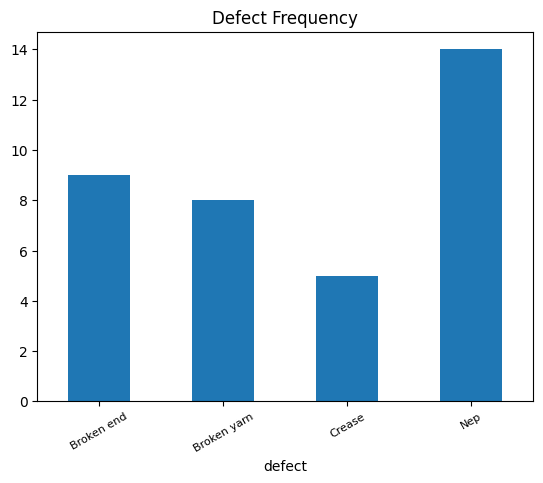

In [5]:
ax = defect_file_df['defect'].value_counts().sort_index().plot(kind = 'bar', title='Defect Frequency')
plt.xticks(range(0,len(DEFECT_CODES) - 1), list(DEFECT_CODES.values())[1:])
ax.xaxis.set_tick_params(rotation=30, labelsize=8)
plt.gca().spines[['top', 'right',]].set_visible(True)

In [6]:
def load_image(file_path: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=1)
    return image, label, file_path

def augment(image, label, path, seed):
    # Make new seed
    new_seed = tf.random.split(seed, num=1)[0, :]
    # Random brightness.
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed
    )
    # random vertical flip
    image = tf.image.stateless_random_flip_up_down(
        image, seed=new_seed
    )

    image = tf.image.stateless_random_contrast(
        image, 0.2, 0.5, seed
    )

    image = tf.clip_by_value(image, 0, 255)
    
    return image, label, path

rng = tf.random.Generator.from_seed(123, alg='philox')

def augment_update(x,y,z):
    seed = rng.make_seeds(1)[:, 0]
    x,y,z = augment(x, y, z, seed)
    return x,y,z

def augment_defect_images(train_ds):
    # used to create more defect images,
    # just a flip and brightness change 
    no_defect_train_image_ds = train_ds.filter(lambda _, label, path: label == 0)
    defect_train_image_ds = train_ds.filter(lambda _, label, path: label > 0)

    augments_per_image = 6
    augmented_defects_ds = (
        defect_train_image_ds
        .repeat(augments_per_image)
        .map(lambda x, y, z: augment_update(x, y, z))
    )
    # print(f"Number of defects before augmentation: {len(list(defect_train_image_ds.as_numpy_iterator()))}\n")
    # print(f"Number of defects after augmentation: {len(list(augmented_defects_ds.as_numpy_iterator()))}\n")
    # print(f"Number of no-defects: {len(list(no_defect_train_image_ds.as_numpy_iterator()))}\n")
    
    defect_train_image_ds = defect_train_image_ds.concatenate(augmented_defects_ds)
    return augmented_defects_ds.concatenate(no_defect_train_image_ds)


In [7]:
def normalize(image, label, file_path):
    image = tf.cast(image, tf.uint8)
    image -= tf.reduce_mean(image, axis=0)
    return image, label

enc = OneHotEncoder()
enc.fit([[i] for i in list(range(len(DEFECT_CODES)))])

spec = tf.TensorSpec(shape=[len(DEFECT_CODES),], dtype=tf.int64)
@tf.py_function(Tout=spec)
def map_defect_to_one_hot(tensor):
    tensor = enc.transform(
        tensor.numpy().reshape(1, 1)
        ).toarray()[0]
    return tensor

#preprocess images
def preprocess_img(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    image = tf.cast(image, tf.uint8)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [224, 224])

    # one hot encode the defects
    label = map_defect_to_one_hot(label)
    return image, label

In [8]:
def shuffle_split(file_ds, seed):
    # shuffle
    ds_size = len(file_ds)
    file_ds = file_ds.shuffle(ds_size, seed=seed, reshuffle_each_iteration=False)

    no_defect_ds = file_ds.filter(lambda _, label: label == 0)
    no_defect_ds_size = len(list(no_defect_ds.as_numpy_iterator()))

    # split
    train_split = 0.70
    no_defect_train_size = int(train_split * no_defect_ds_size)

    val_split = 0.15
    no_defect_val_size = int(val_split * no_defect_ds_size)

    test_split = 0.15

    nodefect_train_ds = no_defect_ds.take(no_defect_train_size)
    nodefect_val_ds = no_defect_ds.skip(no_defect_train_size).take(no_defect_val_size)
    nodefect_test_ds = no_defect_ds.skip(no_defect_train_size).skip(no_defect_val_size)

    defect_ds = file_ds.filter(lambda _, label: label > 0)

    # shuffle no defects and defects to have the same ratio in each group

    defect_ds_size = len(list(defect_ds.as_numpy_iterator()))

    defect_train_size = int(train_split * defect_ds_size)

    defect_val_size = int(val_split * defect_ds_size)

    test_split = 0.15

    defect_train_ds = defect_ds.take(defect_train_size)
    defect_val_ds = defect_ds.skip(defect_train_size).take(defect_val_size)
    defect_test_ds = defect_ds.skip(defect_train_size).skip(defect_val_size)

    train_ds = nodefect_train_ds.concatenate(defect_train_ds)
    val_ds = nodefect_val_ds.concatenate(defect_val_ds)
    test_ds = nodefect_test_ds.concatenate(defect_test_ds)

    train_ds = train_ds.shuffle(defect_train_size + no_defect_train_size, seed=seed, reshuffle_each_iteration=False)
    val_ds = val_ds.shuffle(defect_val_size + defect_val_size, seed=seed, reshuffle_each_iteration=False)
    test_ds = test_ds.shuffle(defect_val_size + defect_val_size, seed=seed, reshuffle_each_iteration=False)

    return train_ds, val_ds, test_ds

def k_fold(file_ds):
    #5 folds
    rng = tf.random.Generator.from_seed(12, alg='philox')
    seeds = rng.make_seeds(5)[:].numpy()[0]

    folds = [shuffle_split(file_ds, seed) for seed in seeds]
    return folds


# Files names to image dataset
full_file_df = pd.concat([defect_file_df, no_defect_file_df])

files_arr = full_file_df['filepath'].to_numpy()
labels_arr = full_file_df['defect'].to_numpy()

# Tf dataset
file_ds = tf.data.Dataset.from_tensor_slices((files_arr, labels_arr))

# get 5 random splits for  cross validation
data_splits = k_fold(file_ds)

def prepare_data(kfold):
    train_ds, val_ds, test_ds = kfold[0], kfold[1], kfold[2],
    val_ds = val_ds.map(load_image)
    test_ds = test_ds.map(load_image)
    train_ds = train_ds.map(load_image)

    rng = tf.random.Generator.from_seed(123, alg='philox')
    aug_train_ds = augment_defect_images(train_ds)

    val_ds = val_ds.map(lambda x,y,z: normalize(x,y,z))
    test_ds = test_ds.map(lambda x,y,z: normalize(x,y,z))
    train_ds = train_ds.map(lambda x,y,z: normalize(x,y,z))
    aug_train_ds = aug_train_ds.map(lambda x,y,z: normalize(x,y,z))

    val_ds = val_ds.map(lambda x,y: preprocess_img(x,y))
    test_ds = test_ds.map(lambda x,y: preprocess_img(x,y))
    train_ds = train_ds.map(lambda x,y: preprocess_img(x,y))
    aug_train_ds = aug_train_ds.map(lambda x,y: preprocess_img(x,y))

    val_ds = val_ds.batch(4, drop_remainder=True)
    test_ds = test_ds.batch(4, drop_remainder=True)
    train_ds = train_ds.batch(4, drop_remainder=True)
    aug_train_ds = aug_train_ds.batch(4, drop_remainder=True)


    for i in aug_train_ds:
        train_shape = (i[0].shape, i[1].shape)
        break

    def set_shapes(image, label):
        image.set_shape(train_shape[0])
        label.set_shape(train_shape[1])
        return image, label

    aug_train_ds = aug_train_ds.map(set_shapes)

    num_batches = len(list(aug_train_ds.as_numpy_iterator()))
    aug_train_ds = aug_train_ds.apply(tf.data.experimental.assert_cardinality(num_batches))
    return aug_train_ds, train_ds, val_ds, test_ds

# prep k fold for training and eval
data_splits = [prepare_data(kfold) for kfold in data_splits]
    

In [9]:
def display_tensor_as_image(tensor: tf.Tensor):
    print(tensor.shape)
    plt.gray()
    plt.imshow(tensor.numpy())
    plt.show()

## Supervised Learning

In [11]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(15,15))
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train','Val'])
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])

In [12]:
def f1_score_matrix(val_ds, head_model):    
    metric = tf.keras.metrics.F1Score()

    test_y_true_ds = [label.numpy() for _, label in val_ds.unbatch()]
    test_y_true_ds = np.array(test_y_true_ds)
    test_y_pred_ds = head_model.predict(val_ds, verbose=2)

    metric.update_state(test_y_true_ds, test_y_pred_ds)
    result = metric.result()

    true_labels = np.array([np.argmax(label) for label in test_y_true_ds])
    pred_labels = np.array([np.argmax(label) for label in test_y_pred_ds])
    tf.math.confusion_matrix(true_labels, pred_labels)
    return result.numpy(), tf.math.confusion_matrix(true_labels, pred_labels)


In [13]:
# Transfer learning on the top layers
# Load convolutional weights that are trained on ImageNet data
def build_model(output_len):
    base_model = tf.keras.applications.resnet.ResNet152(
        weights = 'imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )

    # Freeze pretrained layers
    for layer in base_model.layers:
      layer.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    predictions = tf.keras.layers.Dense(output_len, activation = 'softmax')(x)

    head_model = tf.keras.Model(inputs = base_model.input, outputs = predictions)
    head_model.compile(optimizer='adam', loss= tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return head_model




Epoch 1/6
62/62 [==============================] - 101s 1s/step - loss: 30.1533 - accuracy: 0.7823 - val_loss: 2.7897 - val_accuracy: 0.8269
Epoch 2/6
62/62 [==============================] - 82s 1s/step - loss: 90.0231 - accuracy: 0.7419 - val_loss: 2.4797 - val_accuracy: 0.8462
Epoch 3/6
62/62 [==============================] - 86s 1s/step - loss: 24.2153 - accuracy: 0.7782 - val_loss: 2.1697 - val_accuracy: 0.8654
Epoch 4/6
62/62 [==============================] - 85s 1s/step - loss: 9.6547 - accuracy: 0.8226 - val_loss: 2.4797 - val_accuracy: 0.8462
Epoch 5/6
62/62 [==============================] - 82s 1s/step - loss: 3.6599 - accuracy: 0.8831 - val_loss: 1.8598 - val_accuracy: 0.8846
Epoch 6/6
13/13 [==============================] - 7s 547ms/step - loss: 1.5620 - accuracy: 0.8846
k fold 1 acc 0.8846153616905212
13/13 [==============================] - 7s 555ms/step - loss: 1.5620 - accuracy: 0.8846
13/13 - 10s - 10s/epoch - 785ms/step
k fold 1 f score and confusion matrix (array

(0.8961538434028625,
 array([0.9551922 , 0.33333334, 0.86      , 0.6       , 0.3985714 ],
       dtype=float32),
 <tf.Tensor: shape=(5, 5), dtype=int32, numpy=
 array([[211,   0,   0,   0,   0],
        [  2,   3,   0,   0,   2],
        [  1,   0,   7,   0,   2],
        [  2,   0,   0,   4,   0],
        [ 15,   3,   0,   0,   8]])>)

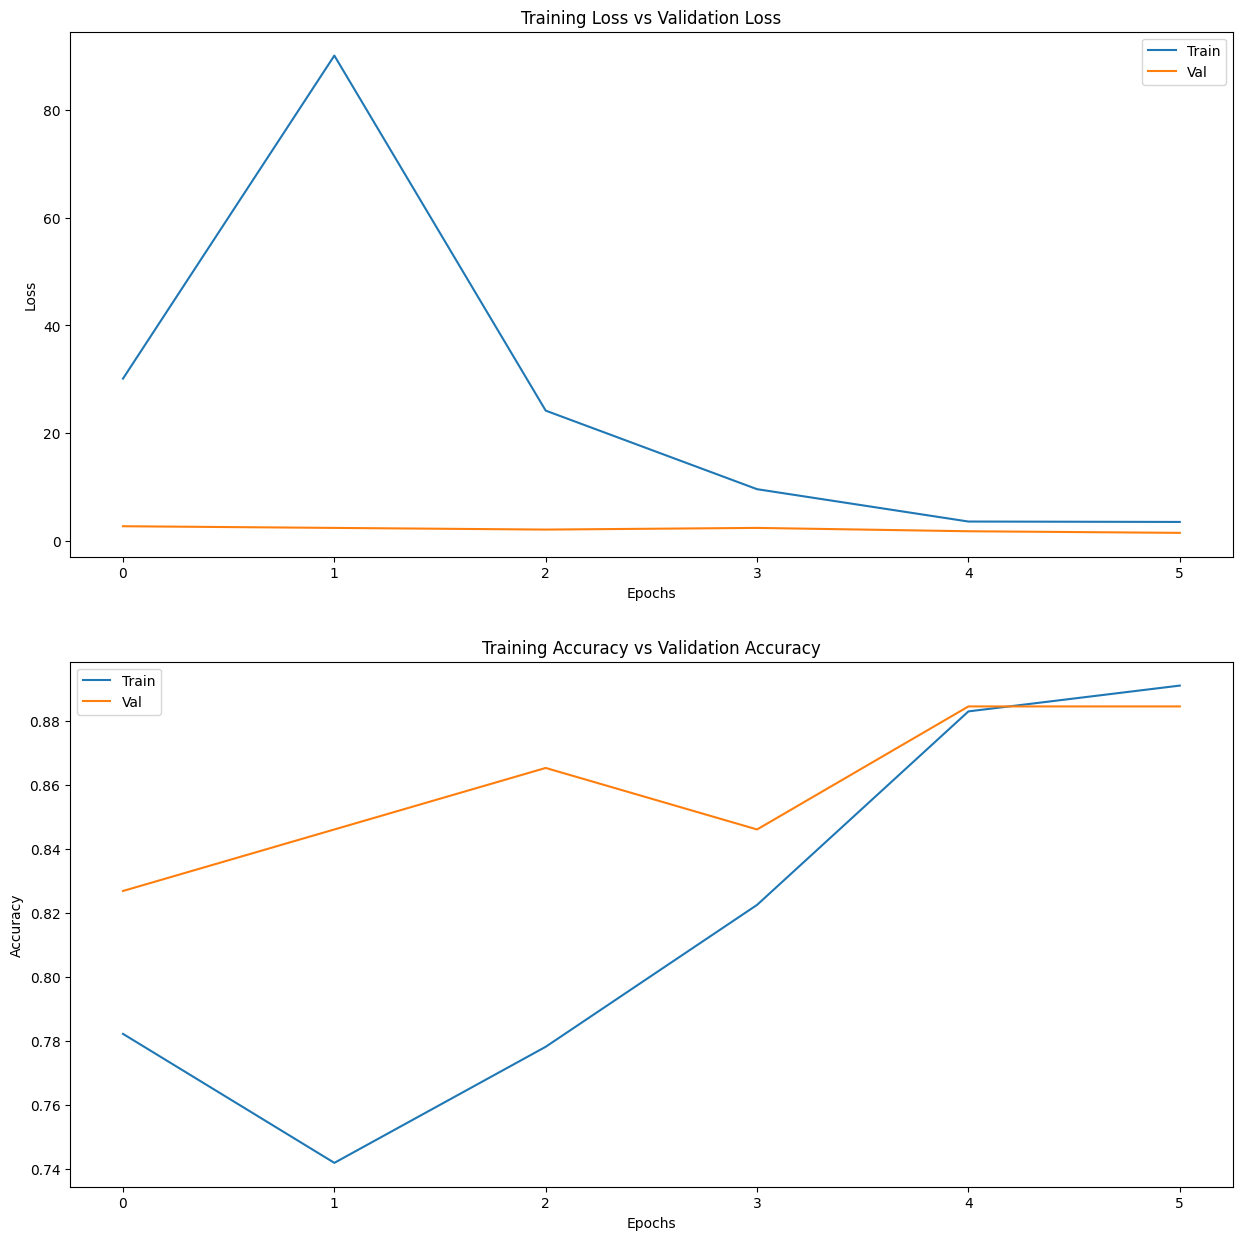

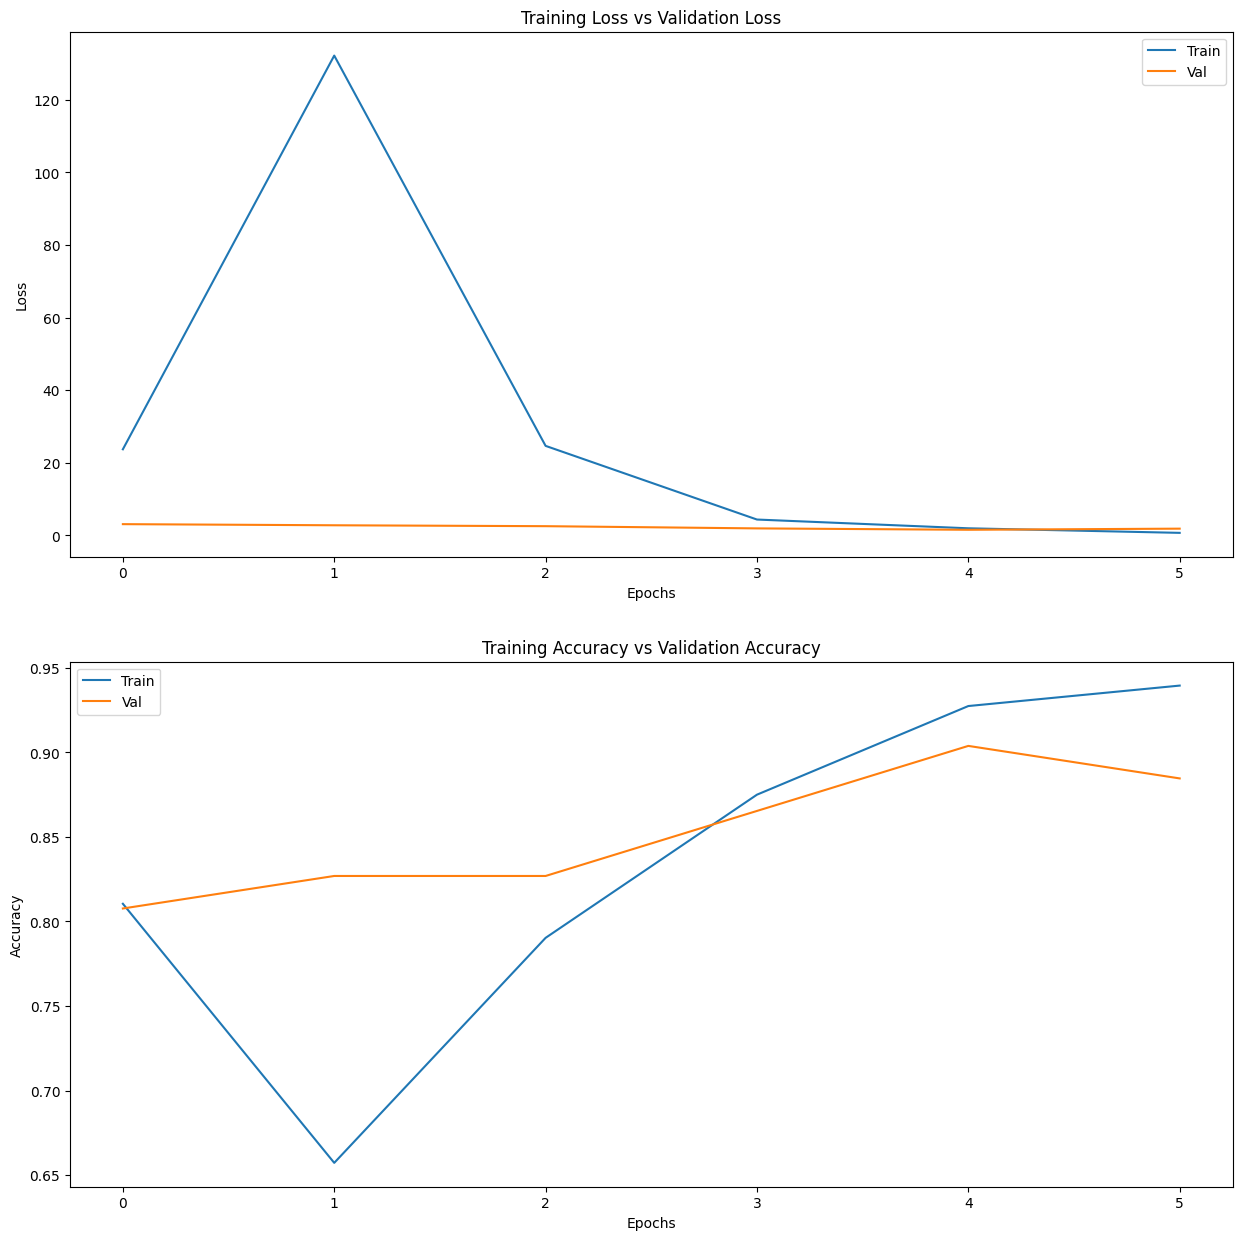

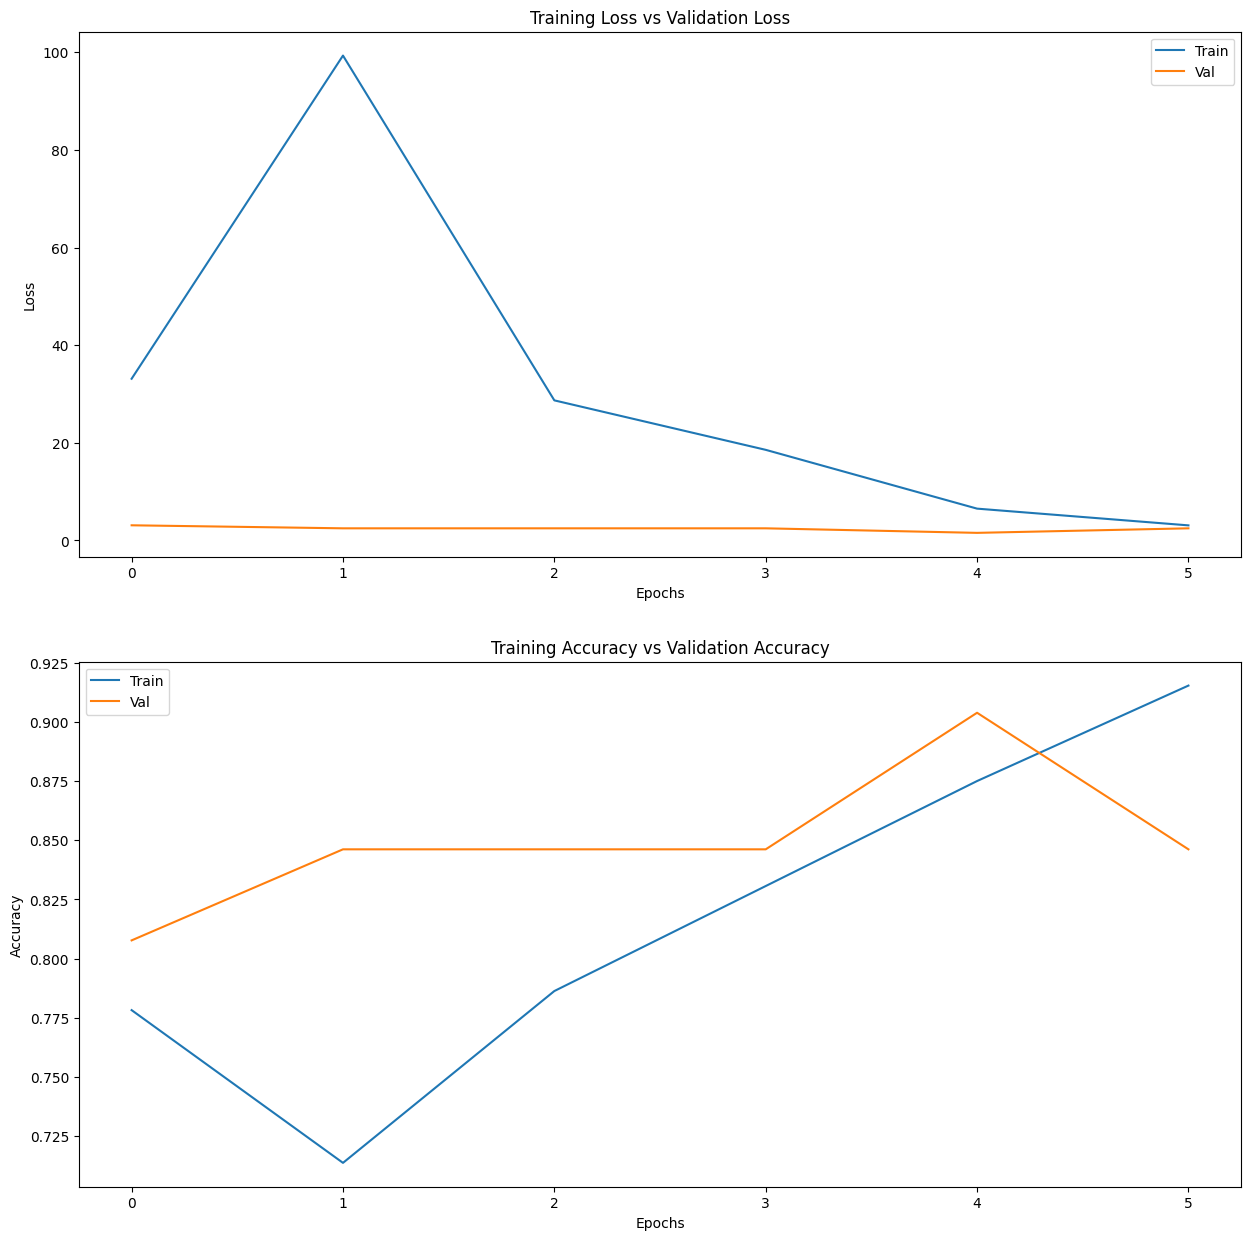

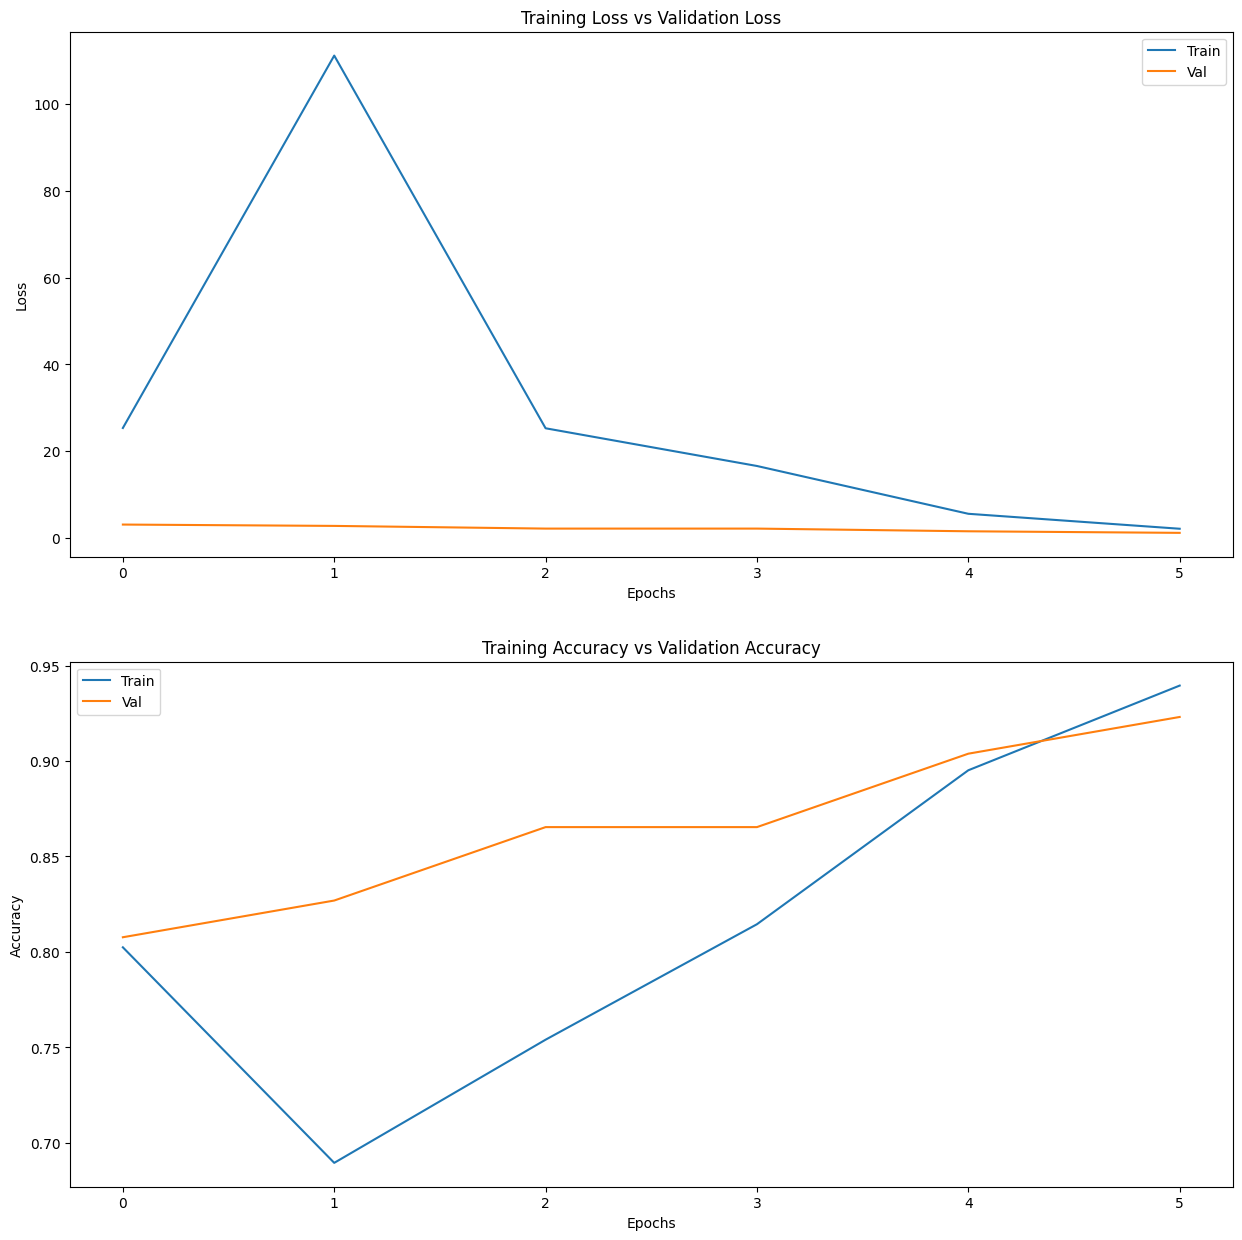

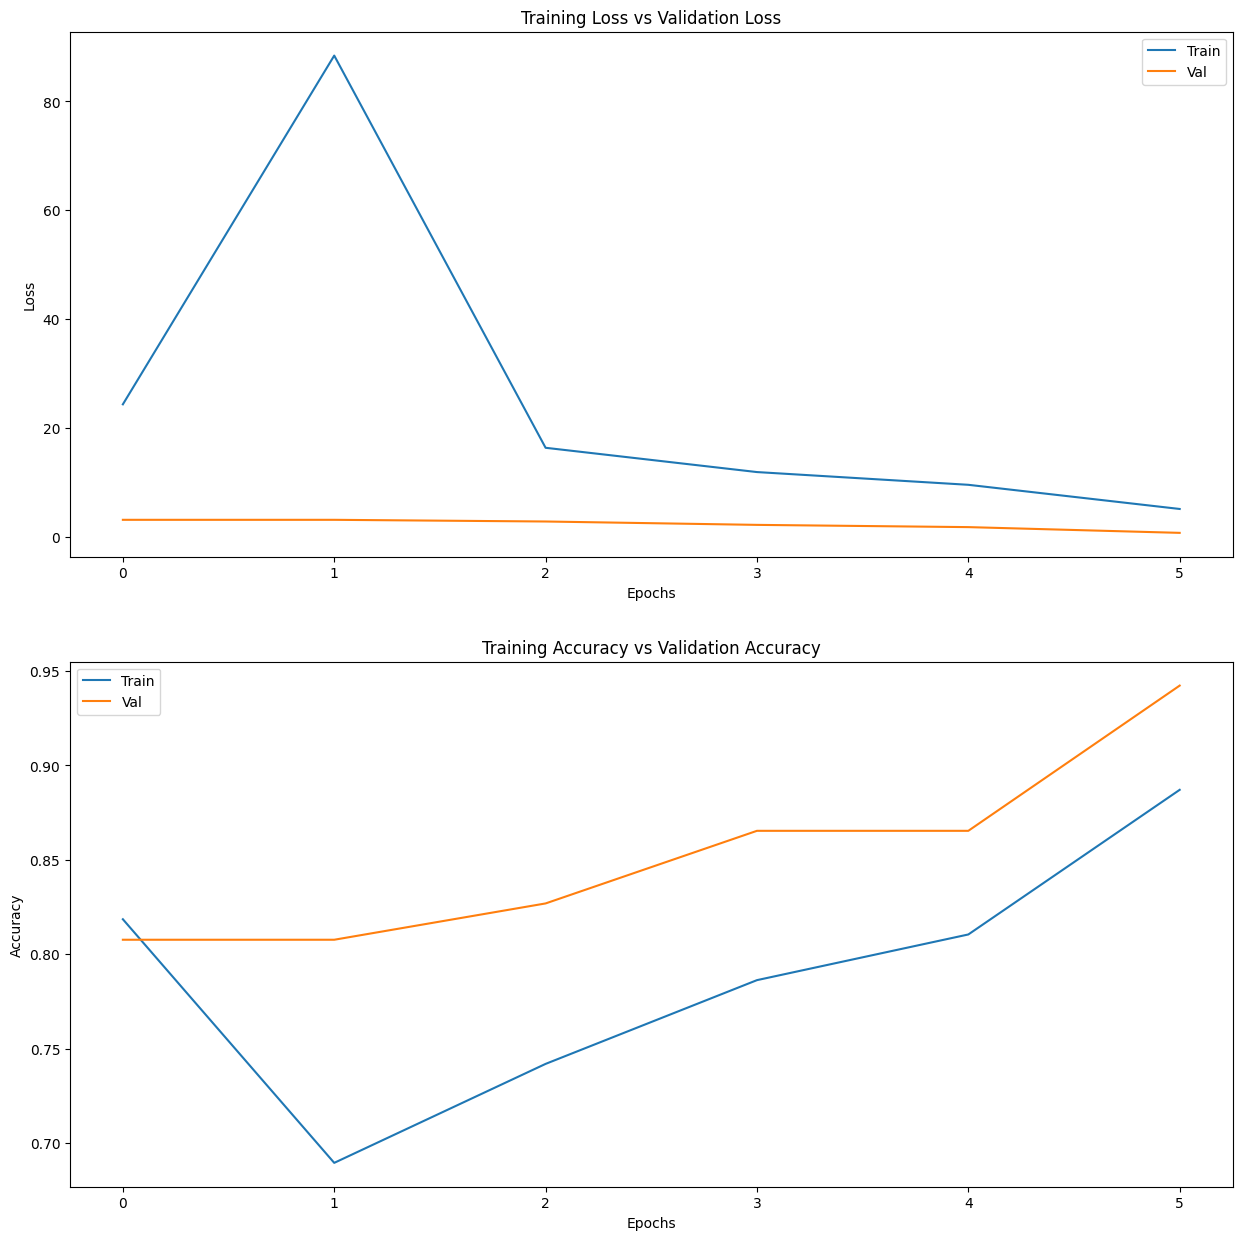

In [16]:
def eval_kfolds(data_splits):
    con_matrix = None
    acc = 0
    f_1 = 0 
    for i, fold in enumerate(data_splits):
        head_model = build_model(output_len)
        aug_train_ds, train_ds, val_ds, test_ds = fold
        val_ds = val_ds.concatenate(test_ds)
        history = head_model.fit(aug_train_ds, epochs= 6, validation_data= val_ds)
        plot_history(history)
        print(f'k fold {i+1} acc {head_model.evaluate(val_ds)[1]}')
        acc += head_model.evaluate(val_ds)[1]
        print(f'k fold {i+1} f score and confusion matrix {f1_score_matrix(val_ds, head_model)}')
        if con_matrix is None:
            f_1 = f1_score_matrix(val_ds, head_model)[0]
            con_matrix = f1_score_matrix(val_ds, head_model)[1]
        else:
            f_1 += f1_score_matrix(val_ds, head_model)[0]
            con_matrix += f1_score_matrix(val_ds, head_model)[1]

    acc = acc/(i+1)
    f_1 = f_1/(i+1)
    return acc, f_1, con_matrix
        


eval_kfolds(data_splits)